Insert the GO annotation in the MySQL database and link them to each protein in the database.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option("display.max_rows", 17)

See http://geneontology.org/docs/go-annotation-file-gaf-format-2.2/ for definitions of columns

In [2]:
go_file = pd.read_csv("goa_human.gaf", sep = "\t", skiprows=41, index_col = False,names = ["DB", "DB_Object_ID", "DB_Object_Symbol", "Qualifier", "GO_ID", "DB:Reference", "Evidence_Code", "With_or_From", "Aspect", "DB_Object_Name", "DB_Object_Synonym", "DB_Object_Type","Taxon", "Date", "Assigned_By", "Annotation_Extension", "Gene_Product_From_ID"])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(go_file.shape)
go_file.head()

(635753, 17)


,DB,DB_Object_ID,DB_Object_Symbol,Qualifier,GO_ID,DB:Reference,Evidence_Code,With_or_From,Aspect,DB_Object_Name,DB_Object_Synonym,DB_Object_Type,Taxon,Date,Assigned_By,Annotation_Extension,Gene_Product_From_ID
0,UniProtKB,A0A024RBG1,NUDT4B,enables,GO:0003723,GO_REF:0000043,IEA,UniProtKB-KW:KW-0694,F,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20220907,UniProt,NaN,NaN
1,UniProtKB,A0A024RBG1,NUDT4B,enables,GO:0046872,GO_REF:0000043,IEA,UniProtKB-KW:KW-0479,F,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20220907,UniProt,NaN,NaN
2,UniProtKB,A0A024RBG1,NUDT4B,located_in,GO:0005829,GO_REF:0000052,IDA,NaN,C,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20161204,HPA,NaN,NaN
3,UniProtKB,A0A075B6H7,IGKV3-7,involved_in,GO:0002250,GO_REF:0000043,IEA,UniProtKB-KW:KW-1064,P,Probable non-functional immunoglobulin kappa v...,IGKV3-7,protein,taxon:9606,20220907,UniProt,NaN,NaN
4,UniProtKB,A0A075B6H7,IGKV3-7,located_in,GO:0005886,GO_REF:0000044,IEA,UniProtKB-SubCell:SL-0039,C,Probable non-functional immunoglobulin kappa v...,IGKV3-7,protein,taxon:9606,20220907,UniProt,NaN,NaN


In [4]:
nsaf = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_creation/pooled_proteome_nsaf_1.csv")
nsaf.head()

,assay_id,uniprot_id,NSAF
0,31056,A0AVT1,0.000333
1,31056,A0JNW5,0.000060
2,31056,A0MZ66,0.000278
3,31056,A2A3N6,0.000102
4,31056,A2RRP1,0.000111


In [5]:
uniprots = nsaf.uniprot_id.unique()
go_prots = go_file.DB_Object_ID.unique()

count = 0
missing = {}
for uniprot in uniprots:
    if uniprot not in go_prots:
        missing[uniprot] = len(nsaf[nsaf.uniprot_id == uniprot])
        count += 1
        
print(count)
missing = pd.DataFrame(pd.Series(missing), columns=["freq"]).reset_index().rename({"index": "uniprot_id"})

225


Example of issue: isoform P42166 · LAP2A_HUMAN is present in GO-table but P42167 · LAP2B_HUMAN not

In [6]:
missing.sort_values("freq", ascending = False).head(10)

,index,freq
0,P42167,331
10,L0R6Q1,294
26,Q7Z422,243
11,Q6ZSJ8,237
5,Q96F63,228
9,E9PRG8,212
28,Q6EEV4,200
20,Q8IV50,163
3,Q9BY89,156
17,Q53LP3,149


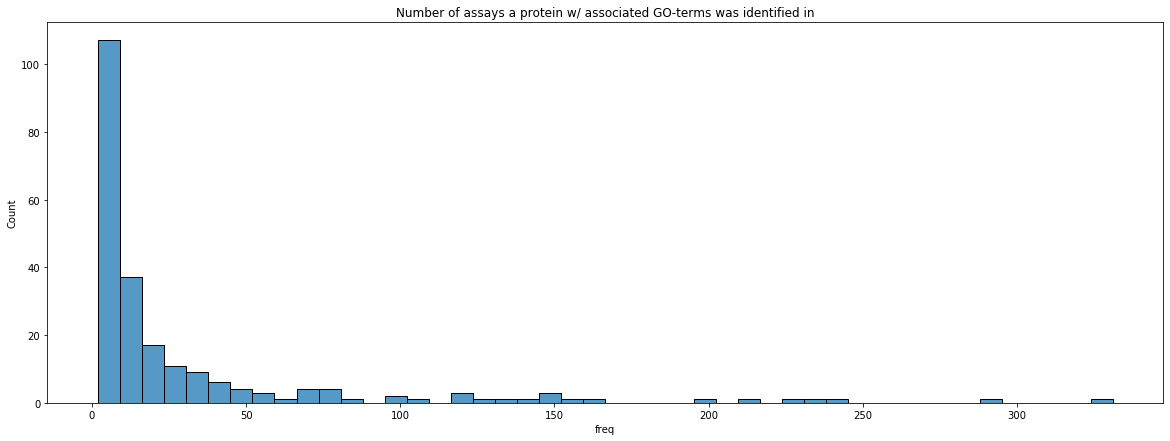

In [8]:
plt.figure(figsize=(20,7))
plt.title("Number of assays a protein with no associated GO-terms was identified in")
sns.histplot(missing.freq)

In [10]:
print(nsaf.shape, go_file.shape)

(1241205, 3) (635753, 17)


In [20]:
uniprots = pd.DataFrame({"uniprot_id":uniprots})
go_annot = go_file.rename({"DB_Object_ID": "uniprot_id"}, axis =1)[["uniprot_id", "GO_ID", "Aspect"]]

In [23]:
uni_go = pd.merge(uniprots, go_annot, on = "uniprot_id").drop_duplicates()
uni_go.head()

,uniprot_id,GO_ID,Aspect
0,A0AVT1,GO:0005515,F
3,A0AVT1,GO:0005524,F
4,A0AVT1,GO:0019780,F
5,A0AVT1,GO:0006511,P
6,A0AVT1,GO:0007612,P


In [30]:
go_file[go_file.DB_Object_ID == "A0AVT1"].head()

,DB,DB_Object_ID,DB_Object_Symbol,Qualifier,GO_ID,DB:Reference,Evidence_Code,With_or_From,Aspect,DB_Object_Name,DB_Object_Synonym,DB_Object_Type,Taxon,Date,Assigned_By,Annotation_Extension,Gene_Product_From_ID
1246,UniProtKB,A0AVT1,UBA6,enables,GO:0005515,PMID:17889673,IPI,UniProtKB:O15205,F,Ubiquitin-like modifier-activating enzyme 6,UBA6|MOP4|UBE1L2,protein,taxon:9606,20100325,UniProt,NaN,NaN
1247,UniProtKB,A0AVT1,UBA6,enables,GO:0005515,PMID:25416956,IPI,UniProtKB:Q6NT76,F,Ubiquitin-like modifier-activating enzyme 6,UBA6|MOP4|UBE1L2,protein,taxon:9606,20220910,IntAct,NaN,NaN
1248,UniProtKB,A0AVT1,UBA6,enables,GO:0005515,PMID:25422469,IPI,UniProtKB:O15205,F,Ubiquitin-like modifier-activating enzyme 6,UBA6|MOP4|UBE1L2,protein,taxon:9606,20170620,UniProt,NaN,NaN
1249,UniProtKB,A0AVT1,UBA6,enables,GO:0005524,GO_REF:0000043,IEA,UniProtKB-KW:KW-0067,F,Ubiquitin-like modifier-activating enzyme 6,UBA6|MOP4|UBE1L2,protein,taxon:9606,20220907,UniProt,NaN,NaN
1250,UniProtKB,A0AVT1,UBA6,enables,GO:0019780,PMID:17889673,IMP,NaN,F,Ubiquitin-like modifier-activating enzyme 6,UBA6|MOP4|UBE1L2,protein,taxon:9606,20100401,UniProt,NaN,NaN


In [36]:
uni_go

,uniprot_id,GO_ID,Aspect
0,A0AVT1,GO:0005515,F
3,A0AVT1,GO:0005524,F
4,A0AVT1,GO:0019780,F
5,A0AVT1,GO:0006511,P
6,A0AVT1,GO:0007612,P
...,...,...,...
487335,Q9H1E1,GO:0061844,P
487337,Q9H1E1,GO:0090501,P
487338,Q9H1E1,GO:0005576,C
487343,Q9H1E1,GO:0005615,C


In [37]:
nsaf

,assay_id,uniprot_id,NSAF
0,31056,A0AVT1,0.000333
1,31056,A0JNW5,0.000060
2,31056,A0MZ66,0.000278
3,31056,A2A3N6,0.000102
4,31056,A2RRP1,0.000111
...,...,...,...
1241200,31633,Q9Y6V7,0.000031
1241201,31633,Q9Y6W5,0.000118
1241202,31633,Q9Y6X9,0.000014
1241203,31633,Q9Y6Y0,0.000138


In [38]:
assays = nsaf['assay_id'].unique()
DataFramaDict = {elem: pd.DataFrame for elem in assays}
for key in DataFramaDict.keys():
    DataFramaDict[key] = nsaf[:][nsaf["assay_id"] ==  key]

In [43]:
DataFramaDict

{31056:       assay_id uniprot_id      NSAF
 0        31056     A0AVT1  0.000333
 1        31056     A0JNW5  0.000060
 2        31056     A0MZ66  0.000278
 3        31056     A2A3N6  0.000102
 4        31056     A2RRP1  0.000111
 ...        ...        ...       ...
 1315     31056     Q9Y679  0.000214
 1316     31056     Q9Y6G9  0.000335
 1317     31056     Q9Y6I3  0.000152
 1318     31056     Q9Y6W5  0.000704
 1319     31056     Q9Y6Y8  0.000350
 
 [1320 rows x 3 columns],
 31057:       assay_id uniprot_id      NSAF
 1320     31057     A0AVT1  0.000763
 1321     31057     A2RRP1  0.000169
 1322     31057     A3KMH1  0.000211
 1323     31057     A3KN83  0.000461
 1324     31057     A5YKK6  0.000507
 ...        ...        ...       ...
 2676     31057     Q9Y6Q9  0.000056
 2677     31057     Q9Y6W3  0.000099
 2678     31057     Q9Y6W5  0.000484
 2679     31057     Q9Y6Y0  0.000125
 2680     31057     Q9Y6Y8  0.000321
 
 [1361 rows x 3 columns],
 31058:       assay_id uniprot_id      NSA

In [52]:
go_file[["GO_ID", "Aspect"]].values[:,1]

array(['F', 'F', 'C', ..., 'C', 'F', 'C'], dtype=object)

In [55]:
go_file[go_file.DB_Object_ID == "Q9Y6W3"].GO_ID.unique().tolist()

['GO:0004175',
 'GO:0004198',
 'GO:0005515',
 'GO:0090541',
 'GO:0010634',
 'GO:0097264',
 'GO:0005634',
 'GO:0005813',
 'GO:0005829',
 'GO:0070062',
 'GO:0006508',
 'GO:0004197']

In [73]:
GODict = {}
for key in DataFramaDict.keys():
    
    assay = DataFramaDict[key]
    GO_df = {}

    for index, row in assay.iterrows():
        protein = row["uniprot_id"]
        abundance = row["NSAF"]

        GO_terms = go_file[go_file.DB_Object_ID == protein].GO_ID.unique().tolist()
        
        for GO_term in GO_terms:
            if GO_term in GO_df.keys():
                GO_df[GO_term] = [GO_df[GO_term][0] + abundance]
            else:
                GO_df[GO_term] = [abundance]
    
    GODict[key] = pd.DataFrame.from_dict(GO_df, orient = "index", columns = ["GO_abundance"])

In [ ]:
GO_PROT_DF = pd.DataFrame()
for key in GODict.keys():
    GO_PROT_DF = GO_PROT_DF.append(GODict[key])